In [2]:
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/python-introduction/004_link_to_lecture_0.ipynb
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from math import *
import qutip
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

# static image plots
%matplotlib inline
# interactive 3D plots
# %matplotlib widget


# qutip.about()

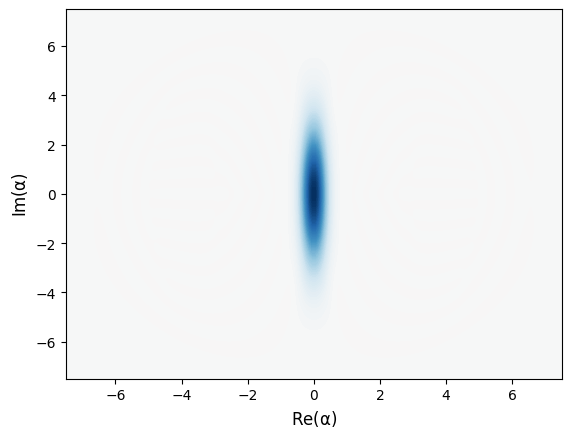

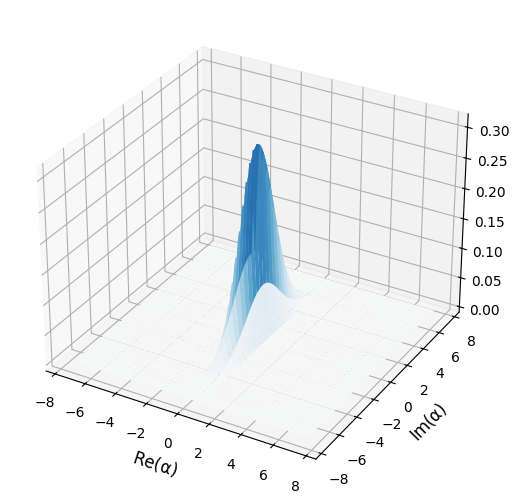

In [3]:
# 1. Setup: Define the Hilbert space dimension
N = 30  # Truncation size

# 2. Create a Vacuum State |0>
psi_0 = qutip.basis(N, 0)

# 3. Manipulate the State
#    Example: Create a Squeezed Coherent State by applying operators
#    First squeeze, then displace: D(alpha) S(xi) |0>

alpha = 0          # Displacement amplitude
xi = 1             # Squeezing parameter

# Get the operators
D = qutip.displace(N, alpha)
S = qutip.squeeze(N, xi)

# Apply them to vacuum (Order matters! Mathematically usually S then D)
psi_squeezed = D * S * psi_0

# Alternatively, generate a coherent state directly and then squeeze it:
# psi_coherent = qutip.coherent(N, alpha)
# psi_squeezed = S * psi_coherent

# 4. Visualization
# Plotting
qutip.plot_wigner(psi_squeezed)
plt.show()

qutip.plot_wigner(psi_squeezed, projection='3d')
plt.show()

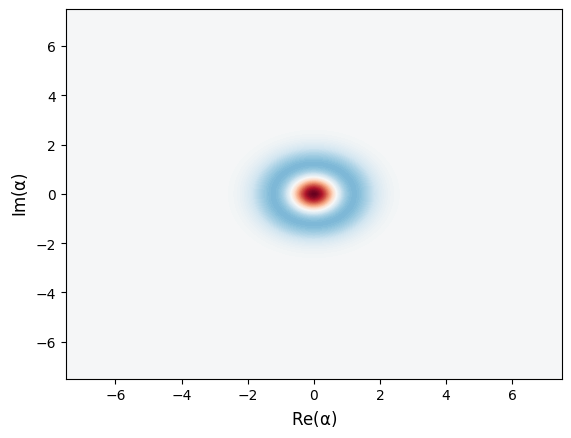

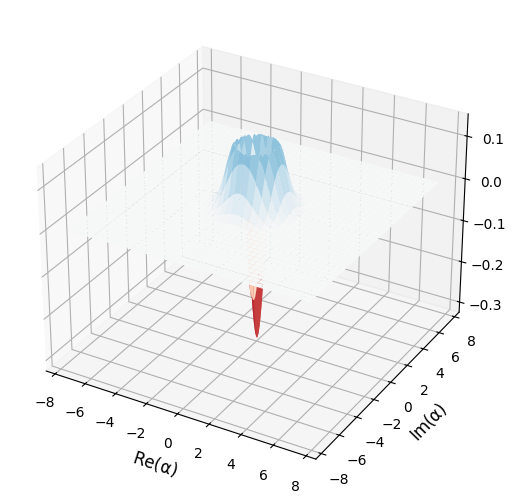

In [4]:
N = 30  # Truncation size

one_state = qutip.basis(N, 1)

# Plotting
qutip.plot_wigner(one_state)
plt.show()

qutip.plot_wigner(one_state, projection='3d')
plt.show()

In [5]:
N = 100  # Truncation size
def generate_fock_coherent_state(displacement, expansion_terms=N):
    alpha = displacement/sqrt(2)
    psi = sum( [((alpha**n)/(sqrt(factorial(n))))*qutip.basis(N, n) for n in range(0, expansion_terms)])
    psi = psi.unit()
    #print(np.absolute(psi.data.to_array()))
    return psi

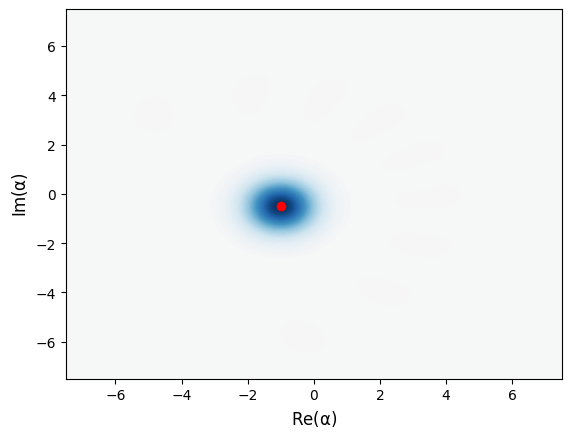

In [6]:
disp = -1+-0.5j

psi = generate_fock_coherent_state(disp, 10)

qutip.plot_wigner(psi)
plt.plot(np.real(disp), np.imag(disp), 'ro')
plt.show()


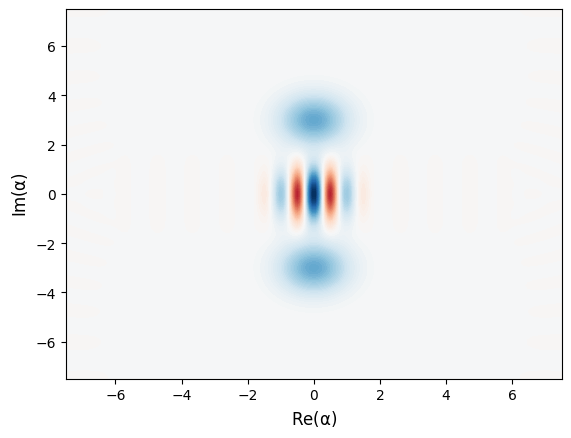

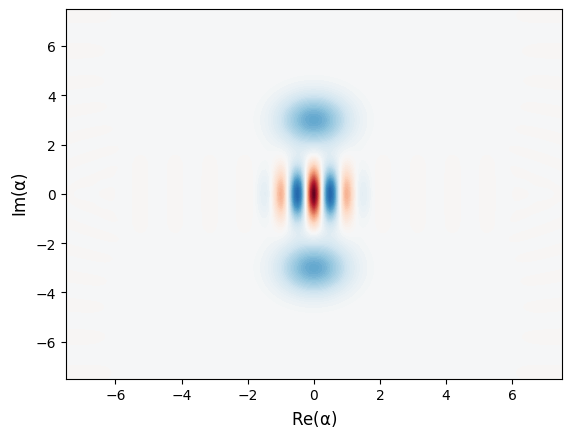

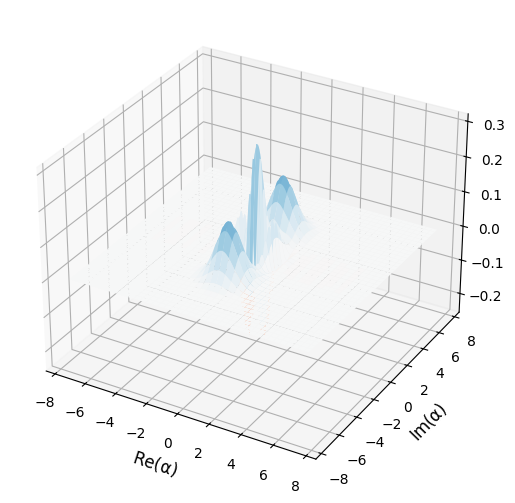

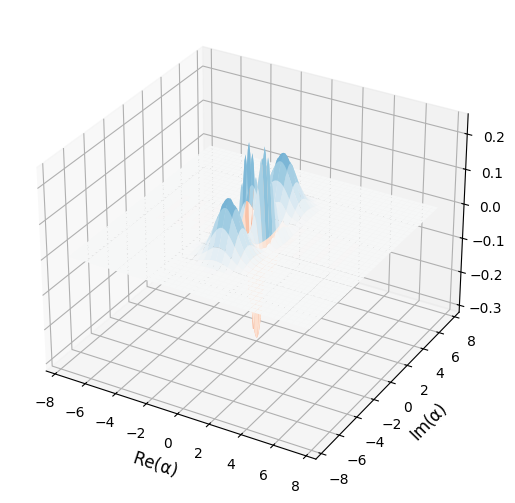

In [7]:
disp = 3j

alpha = generate_fock_coherent_state(disp, 100)
minus_alpha = generate_fock_coherent_state(-disp, 100)

plus = (alpha + minus_alpha).unit()
minus = (alpha - minus_alpha).unit()

qutip.plot_wigner(plus)
plt.show()
qutip.plot_wigner(minus)
plt.show()

qutip.plot_wigner(plus, projection='3d')
plt.show()
qutip.plot_wigner(minus, projection='3d')
plt.show()

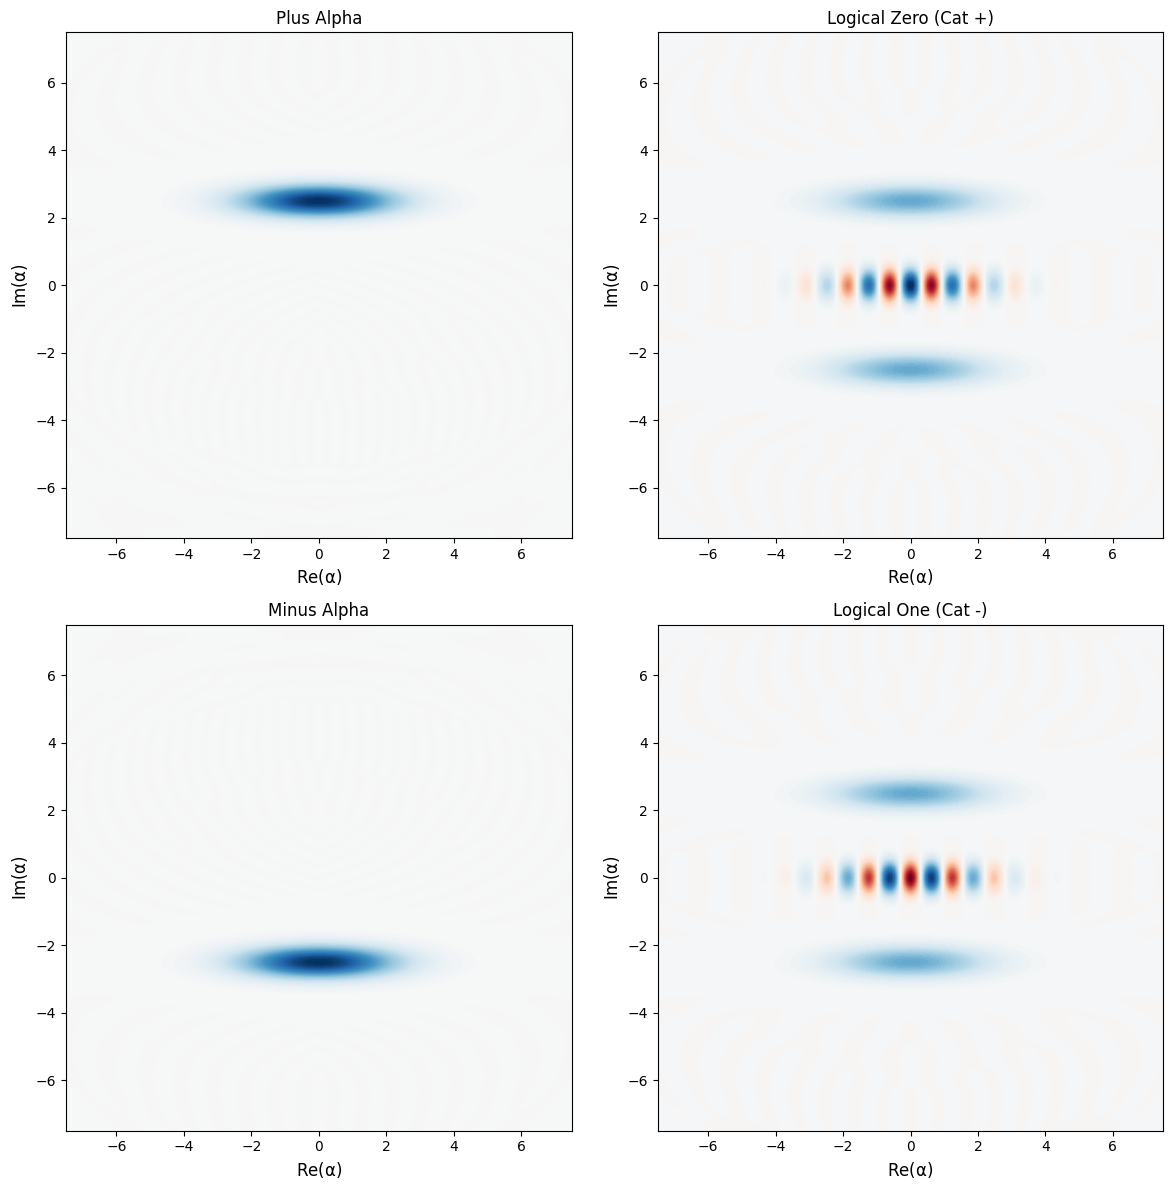

In [8]:
N = 50
zero = qutip.basis(N, 0)

vertical_displacement = 2.5

alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qutip.displace(N, alpha_coeff)
negative_displacement_operator = qutip.displace(N, -alpha_coeff)

squeezing_factor = -0.8 # ???
squeeze_operator = qutip.squeeze(N, squeezing_factor)
 


plus_alpha_state = positive_displacement_operator * squeeze_operator * zero
minus_alpha_state = negative_displacement_operator * squeeze_operator * zero

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()


fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
qutip.plot_wigner(plus_alpha_state, ax=axes[0, 0])
axes[0, 0].set_title("Plus Alpha")
qutip.plot_wigner(minus_alpha_state, ax=axes[1, 0])
axes[1, 0].set_title("Minus Alpha")
qutip.plot_wigner(logical_zero, ax=axes[0, 1])
axes[0, 1].set_title("Logical Zero (Cat +)")
qutip.plot_wigner(logical_one, ax=axes[1, 1])
axes[1, 1].set_title("Logical One (Cat -)")
plt.tight_layout()
plt.show()

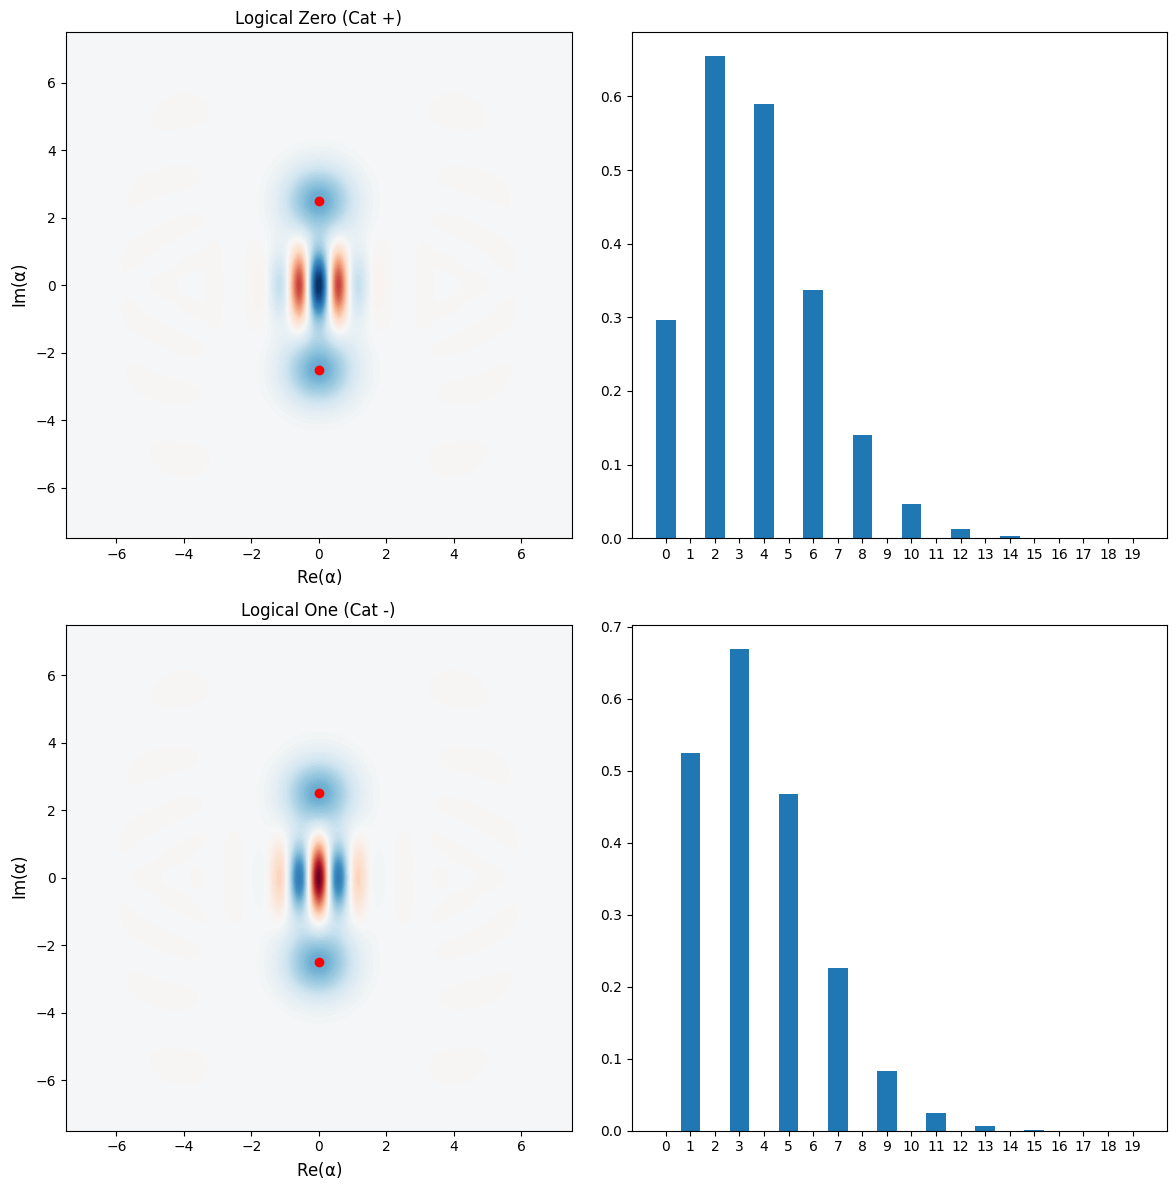

In [44]:
N = 20
vacuum = qutip.basis(N, 0)

vertical_displacement = 2.5


alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qutip.displace(N, alpha_coeff)
negative_displacement_operator = qutip.displace(N, -alpha_coeff)


plus_alpha_state = positive_displacement_operator * vacuum
minus_alpha_state = negative_displacement_operator * vacuum

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()


fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
qutip.plot_wigner(logical_zero, ax=axes[0, 0])
axes[0, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0, 0].set_title("Logical Zero (Cat +)")
qutip.plot_wigner(logical_one, ax=axes[1, 0])
axes[1, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[1, 0].set_title("Logical One (Cat -)")


axes[0, 1].bar(np.arange(N), np.abs(logical_zero.full()).flatten())
axes[0, 1].set_xticks(np.arange(N))
axes[0, 1].set_aspect('auto')
axes[1, 1].bar(np.arange(N), np.abs(logical_one.full()).flatten())
axes[1, 1].set_xticks(np.arange(N))
axes[1, 1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [72]:
def join_modes(mode1: qutip.Qobj, mode2: qutip.Qobj) -> qutip.Qobj:
    """Merges two independent modes into a joint Hilbert space (tensor product)."""
    return qutip.tensor(mode1, mode2)

def separate_modes(joint_state: qutip.Qobj):
    """
    Takes a joint state (2 modes) and returns the reduced density matrices 
    for mode 1 and mode 2 respectively (Partial Trace).
    """
    # Verify the state has two subsystems
    if len(joint_state.dims[0]) != 2:
        raise ValueError("State does not appear to be a 2-mode system.")
        
    return joint_state.ptrace(0), joint_state.ptrace(1)

def beamsplitter_general(input_state: qutip.Qobj, input_2: qutip.Qobj = None, transmissivity: float = 0.5) -> qutip.Qobj:
    """
    Applies a beamsplitter interaction.
    
    Args:
        input_state: Either a joint state (2 modes) OR the state for Mode 1.
        input_2: (Optional) If input_state is Mode 1, this must be Mode 2.
        transmissivity: Probability of swapping modes (0 to 1).
                        T=0 is Identity, T=1 is full Swap, T=0.5 is 50:50.
    
    Returns:
        The evolved joint state (Ket or Density Matrix).
    """
    
    # 1. Standardize Input: Ensure we have one Joint State
    if input_2 is not None:
        # Case A: User provided two separate modes -> Tensor them
        state = qutip.tensor(input_state, input_2)
    else:
        # Case B: User provided a pre-existing joint state
        state = input_state
        # Validation: Ensure it actually has 2 modes
        if len(state.dims[0]) != 2:
            raise ValueError("Input provided is not a joint 2-mode system (dims must imply tensor structure).")

    # 2. Extract Dimensions
    # state.dims looks like [[N1, N2], [N1, N2]] for density matrices
    # or [[N1, N2], [1, 1]] for kets.
    # We grab the first list to get the Hilbert space sizes.
    N1 = state.dims[0][0]
    N2 = state.dims[0][1]

    if N1 != N2:
        # While physically possible, usually in simulation we keep cutoff dims identical
        # to allow swapping without dimension mismatch errors.
        raise ValueError(f"Mode dimensions mismatch: {N1} vs {N2}")
    
    N = N1

    # 3. Define Operators on the Joint Space
    a = qutip.destroy(N)
    
    # a1 acts on first subspace, identity on second
    a1 = qutip.tensor(a, qutip.qeye(N))
    # a2 acts on identity on first, normal on second
    a2 = qutip.tensor(qutip.qeye(N), a)

    # 4. mixing angle theta
    # Transmissivity T = sin^2(theta)
    theta = np.arcsin(np.sqrt(transmissivity))

    # 5. Beamsplitter Unitary
    # U = exp( theta * (a1^dag a2 - a1 a2^dag) )
    generator = theta * (a1.dag() * a2 - a1 * a2.dag())
    U_bs = generator.expm()

    # 6. Apply Unitary
    if state.isket:
        return U_bs * state
    else:
        return U_bs * state * U_bs.dag()


def apply_loss_channel(input_qumode: qutip.Qobj, trasmissivity: float):
    N_input = input_qumode.shape[0]
    vacuum = qutip.basis(N_input, 0)
    output_qumode, _ = separate_modes(beamsplitter_general(input_qumode, vacuum, 1-trasmissivity))
    return output_qumode


In [64]:
def photon_count_distribution(state: qutip.Qobj):
    """
    Returns the photon number distribution P(n) for any state.
    """
    if state.isket:
        # For Kets: |Amplitude|^2
        # We flatten it to get a 1D array
        return np.abs(state.full().flatten())**2
    else:
        # For Density Matrices: Extract the diagonal
        # We take .real to discard any +0j imaginary artifacts
        return np.real(state.diag())

(0.0, 1.0)

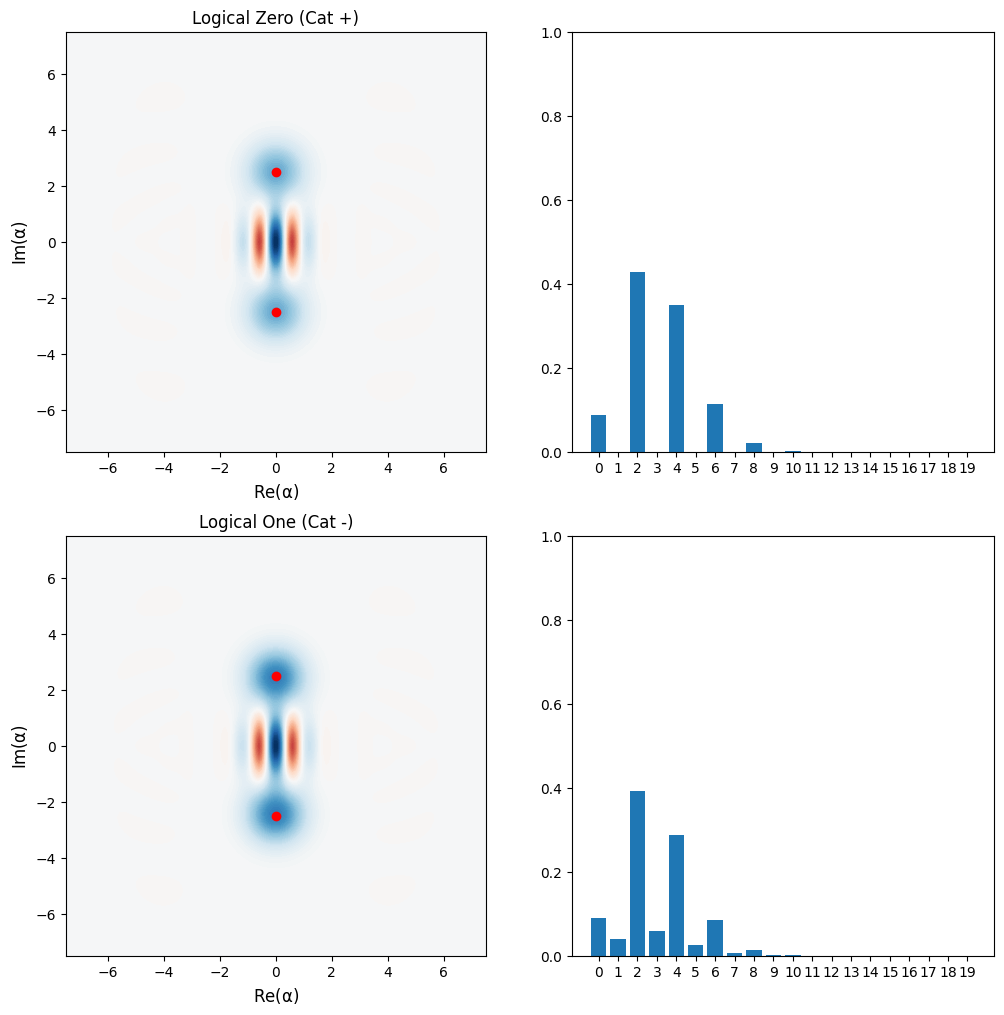

In [ ]:
output = apply_loss_channel(logical_zero, 0.95)

fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
qutip.plot_wigner(logical_zero, ax=axes[0, 0])
axes[0, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0, 0].set_title("Logical Zero (Cat +)")
qutip.plot_wigner(output, ax=axes[1, 0])
axes[1, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[1, 0].set_title("Logical One (Cat -)")


axes[0, 1].bar(np.arange(N), photon_count_distribution(logical_zero))
axes[0, 1].set_xticks(np.arange(N))
axes[0, 1].set_aspect('auto')
axes[0, 1].set_ylim(0, 1)
axes[1, 1].bar(np.arange(N), photon_count_distribution(output))
axes[1, 1].set_xticks(np.arange(N))
axes[1, 1].set_aspect('auto')
axes[1, 1].set_ylim(0, 1)